In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Extracting the data to be fitted

In [67]:
# # Extract excel data into dataframe format using Pandas
# steel_316L_4404_df = pd.read_excel('steel_316L_4404_result.xlsx', engine='openpyxl')
# steel_316L_4420_df = pd.read_excel('steel_316L_4420_result.xlsx', engine='openpyxl')
# # converting the pandas series to numpy arrays
# steel_316L_4404_grain_diameter = steel_316L_4404_df['grain_diameter'].to_numpy()
# steel_316L_4420_grain_diameter = steel_316L_4420_df['grain_diameter'].to_numpy()
# # checking the shape of the arrays
# print(steel_316L_4404_grain_diameter.shape)
# print(steel_316L_4420_grain_diameter.shape)

# Extract excel data into dataframe format using Pandas
steel_316L_4404_df = pd.read_excel('steel_316L_4404_grain_size_probability.xlsx', engine='openpyxl')
steel_316L_4420_df = pd.read_excel('steel_316L_4420_grain_size_probability.xlsx', engine='openpyxl')
# converting the pandas series to numpy arrays
steel_316L_4404_low_bin = steel_316L_4404_df['low_bin'].to_numpy()
steel_316L_4404_high_bin = steel_316L_4404_df['high_bin'].to_numpy()
steel_316L_4404_probability = steel_316L_4404_df['probability'].to_numpy()
steel_316L_4420_low_bin = steel_316L_4420_df['low_bin'].to_numpy()
steel_316L_4420_high_bin = steel_316L_4420_df['high_bin'].to_numpy()
steel_316L_4420_probability = steel_316L_4420_df['probability'].to_numpy()

# assert that the bin magnitude is constant
steel_316L_4404_diff_bin = np.diff(steel_316L_4404_high_bin)
assert np.allclose(steel_316L_4404_diff_bin, steel_316L_4404_diff_bin[0])
steel_316L_4420_diff_bin = np.diff(steel_316L_4420_high_bin)
assert np.allclose(steel_316L_4420_diff_bin, steel_316L_4420_diff_bin[0])

In [63]:
from distributions_pdf import *
from distributions_cdf import *
from scipy.optimize import minimize

distribution_pdf_dict = {
    "normal": normal_pdf,
    "lognormal": lognormal_pdf,
    "beta": beta_pdf,
}

didstribution_cdf_dict = {
    "normal": normal_cdf,
    "lognormal": lognormal_cdf,
    "beta": beta_cdf,
}

def kullback_leibler_divergence(params, x_data, y_data, pdf_function):
    """
    Compute the Kullback-Leibler (KL) divergence between the true and estimated distributions.

    params: tuple - Parameters to optimize (e.g., mean and std for normal distribution)
    x_data: array - Observed data points
    y_data: array - True probability values associated with x_data (empirical probabilities)
    pdf_function: function - Probability density function (PDF) to optimize

    Returns:
        KL divergence value.
    """
    q_model = pdf_function(x_data, *params)  # Model distribution Q(x)
    q_model = np.where(q_model > 0, q_model, 1e-10)  # Prevent log(0)
    
    return np.sum(y_data * np.log(y_data / q_model))  # KL Divergence


def fit_distribution_bins(low_bin, high_bin, probability, distribution = 'normal'): 
    """
    Fit a probability distribution to binned data using Maximum Likelihood Estimation (MLE).

    Parameters:
        low_bin (array): Lower edges of bins.
        high_bin (array): Upper edges of bins.
        probability (array): Probability for each bin.
        distribution (str): The name of the distribution to fit.

    Returns:
        best_params (tuple): Estimated distribution parameters.
        log_likelihood (float): Log-likelihood value for the fit.
    """

    # Compute bin centers
    bin_centers = (low_bin + high_bin) / 2
    
    # Select custom PDF
    if distribution not in distribution_pdf_dict:
        raise ValueError(f"⚠️ Distribution '{distribution}' not found. Choose from {list(distribution_pdf_dict.keys())}")

    pdf_function = distribution_pdf_dict[distribution]

    # Initial parameter guesses based on the selected distribution
    if distribution == "normal":
        initial_guess = [np.mean(bin_centers), np.std(bin_centers)] # Mean and Standard Deviation
    elif distribution == "lognormal":
        initial_guess = [np.log(np.mean(bin_centers)), np.std(np.log(bin_centers))] # Mean and Standard Deviation
    elif distribution == "beta":
        initial_guess = [1, 1]  # Alpha and Beta parameters

    # Perform Maximum Likelihood Estimation (MLE) using optimization
    result = minimize(fun=kullback_leibler_divergence, x0=initial_guess, 
                    args=(bin_centers, probability, pdf_function), method='BFGS')

    if result.success:
        best_params = result.x
        best_fun = result.fun
        return best_params, best_fun
    else:
        raise RuntimeError(f"⚠️ Optimization failed: {result.message}")

In [64]:
# Fit distributions to the data using our custom PDFs
best_fit_4404, KL_div_4404 = fit_distribution_bins(
    steel_316L_4404_df['low_bin'], 
    steel_316L_4404_df['high_bin'], 
    steel_316L_4404_df['probability'], 
    distribution="lognormal"
)

best_fit_4420, KL_div_4420 = fit_distribution_bins(
    steel_316L_4420_df['low_bin'], 
    steel_316L_4420_df['high_bin'], 
    steel_316L_4420_df['probability'], 
    distribution="lognormal"
)

print(f"✅ 316L_4404 Best Fit (Lognormal): {best_fit_4404}, KL divergence: {KL_div_4404}")
print(f"✅ 316L_4420 Best Fit (Lognormal): {best_fit_4420}, KL divergence: {KL_div_4420}")

✅ 316L_4404 Best Fit (Lognormal): [1.74417678 0.75551068], KL divergence: 0.7969242059208234
✅ 316L_4420 Best Fit (Lognormal): [1.52140367 0.69751198], KL divergence: 0.7455045228381298


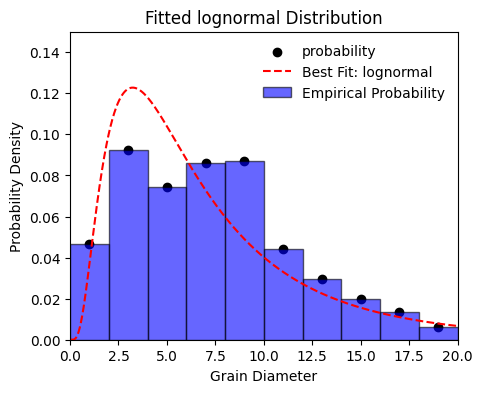

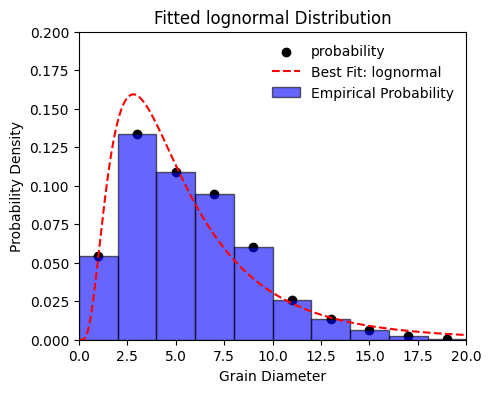

In [75]:
# Plot the fitted distribution using the optimized parameters
def plot_fitted_distribution(new_x, low_bin, high_bin, probability,
                        x_lim, y_lim, best_params, pdf_function, dist_name):
    bin_centers = (low_bin + high_bin) / 2
    bin_widths = high_bin - low_bin  # Compute bin widths
    fitted_pdf = pdf_function(new_x, *best_params)

    # NOTE: The bin width must be constant for all bins. Otherwise it cannot be plotted
    bin_width = high_bin[0] - low_bin[0]
    plt.figure(figsize=(5, 4))
    plt.scatter(bin_centers, probability/bin_width, label="probability", color="black")
    plt.bar(bin_centers, probability/bin_width, width=bin_widths, alpha=0.6, color="blue", edgecolor="black", label="Empirical Probability")
    
    plt.plot(new_x, fitted_pdf, label=f"Best Fit: {dist_name}", linestyle="dashed", color="red")
    plt.legend(frameon=False)
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    plt.xlabel("Grain Diameter")
    plt.ylabel("Probability Density")
    plt.title(f"Fitted {dist_name} Distribution")
    plt.show()

new_x = np.linspace(0, 20, 1000)
x_lim = (0, 20)
y_lim = (0, 0.15)
# Plot for Steel 316L_4404
plot_fitted_distribution(
    new_x,
    steel_316L_4404_df['low_bin'], 
    steel_316L_4404_df['high_bin'], 
    steel_316L_4404_df['probability'], 
    x_lim, y_lim, 
    best_fit_4404, 
    lognormal_pdf, 
    "lognormal"
)

new_x = np.linspace(0, 20, 1000)
x_lim = (0, 20)
y_lim = (0, 0.2)
# Plot for Steel 316L_4420
plot_fitted_distribution(
    new_x,
    steel_316L_4420_df['low_bin'], 
    steel_316L_4420_df['high_bin'], 
    steel_316L_4420_df['probability'], 
    x_lim, y_lim, 
    best_fit_4420, 
    lognormal_pdf, 
    "lognormal"
)